# Introduction
In this notebook models are created for both league prediction and smurf detection. Three algorithms used for each of these models. Data is scaled using RobustScaler and gridsearching is also carried out to ensure the optimial hyperparameters are chosen. Thresholding is carried out for the smurf detection model to obtain the desired recall rate. A misclassification dataframe is created for the smurf detector to examine patterns amongst the misclassifications.

## Table of Contents
- [Import Libraries](#section1)
- [League Prediction Model](#section2)
    - [K Nearest Neighbors](#section3)
    - [Logisitic Regression](#section4)
    - [Random Forest Classifier](#section5)
- [Smurf Detector](#section6)
    - [K Nearest Neighbors](#section7)
    - [Logisitic Regression](#section8)
    - [Random Forest Classifier](#section9)
- [Thresholding](#section10)
- [Misclassifications](#section11)

### Import Libraries <a name="section1"></a>
Import necessary libraries and load dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier#Number of trees, max features, depth, sample depth
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression#C, L1 ratio 
from sklearn.preprocessing import RobustScaler

In [2]:
#Make graphs pretty and bigger
plt.rcParams['figure.figsize'] = (10, 10)
sns.set()
#Suppress warnings for prettier output
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Load dataset
starcraft_data = pd.read_csv('wrangled_starcraft_data.csv')
starcraft_data.drop('Unnamed: 0', axis=1, inplace=True)
starcraft_data.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27.0,10.0,3000.0,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23.0,10.0,5000.0,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30.0,10.0,200.0,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19.0,20.0,400.0,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32.0,10.0,500.0,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


### League Prediction Model <a name="section2"></a>
Here three algorithms are used to predict league placements. They are gridsearched for accuarcy. 

Since this is going to be a league placement classifier, a few things need to be adjusted. First, players can't be placed into Professional or Grandmaster leagues, so these will be removed. This will also handle missing data from the Professional league. Next, this model will place new accounts so they will have no play time. Also, the age and hours per week features were collected by participants submitting this information with their replays for analysis and blizzard does not track these stats anyways, so they will be removed. 

In [4]:
#Drop Age, HoursPerWeek and TotalHours. Also drop leagues 7 and 8. 
starcraft_data = starcraft_data.drop(starcraft_data[(starcraft_data['LeagueIndex'] == 7) |
                                                   (starcraft_data['LeagueIndex'] == 8)].index)
starcraft_data = starcraft_data.drop(['Age', 'HoursPerWeek', 'TotalHours'], axis=1)
starcraft_data.head()

,GameID,LeagueIndex,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [5]:
#Ensure Leagues 7 and 8 have been dropped
starcraft_data['LeagueIndex'].unique()

array([5, 4, 3, 2, 1, 6], dtype=int64)

#### K Nearest Neighbors <a name="section3"></a>

In [6]:
#Create training and testing split for K neighbors 
X = starcraft_data.drop(['LeagueIndex', 'GameID'], axis=1)
y = starcraft_data['LeagueIndex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
#Scale Data
robust = RobustScaler()
X_train = pd.DataFrame(robust.fit_transform(X_train), 
                       columns=starcraft_data.drop(['GameID', 'LeagueIndex'], axis=1).columns)
#Transform test data in the same manner as the training data. 
X_test = pd.DataFrame(robust.transform(X_test), 
                       columns=starcraft_data.drop(['GameID', 'LeagueIndex'], axis=1).columns)

In [7]:
#Create model and gridsearch
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 50)}
knn_gs = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
knn_gs.fit(X_train, y_train)
print('Best parameter for n_neighbors is {}'.format(knn_gs.best_params_['n_neighbors']))
print('Scoring {}'.format(knn_gs.best_score_))

Best parameter for n_neighbors is 41
Scoring 0.3615909090909091


This tells us the best value is 49 for number of neighbors, so let's make this model.

In [8]:
knn_final = KNeighborsClassifier(n_neighbors=41)
knn_final.fit(X_train, y_train)
knn_final.score(X_test, y_test)

0.37122128174123337

#### Logistic Regression <a name="section4"></a>

In [9]:
#Create new model and gridsearch
log = LogisticRegression(solver='newton-cg')
param_grid = {'C':np.logspace(-4, 4, 10), 'penalty': ['l1', 'l2']}
log_gs = GridSearchCV(log, param_grid, cv=5, scoring='accuracy')
log_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='newton-cg'),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [10]:
#Get gridsearch results
print('Best parameter for n_neighbors is {}'.format(log_gs.best_params_))
print('Scoring {}'.format(log_gs.best_score_))

Best parameter for n_neighbors is {'C': 0.046415888336127774, 'penalty': 'l2'}
Scoring 0.38862414467253176


In [11]:
log_final = LogisticRegression(C=0.046, penalty='l2', solver='newton-cg')
log_final.fit(X_train, y_train)
y_pred_log = log_final.predict(X_test)
log_final.score(X_test, y_test)

0.4147521160822249

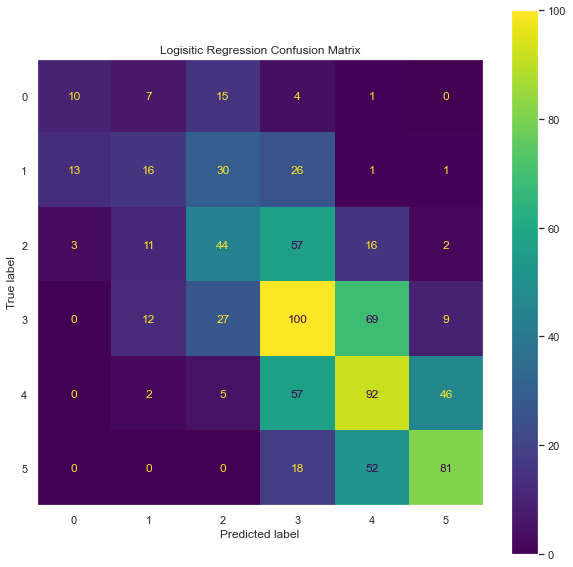

In [12]:
#Print confusion matrix for final Logistic Regression model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Logisitic Regression Confusion Matrix')
plt.grid(False)

In [13]:
#Get adjusted accuracy score. This score tells us how accurate the model is when the model predicts 
# +/-1 leagues within the true value. 
total = 0
for idx, val in enumerate(y_pred_log):
    if ((y_pred_log[idx] == y_test.iloc[idx]) or (y_pred_log[idx] == y_test.iloc[idx] - 1)
                                          or (y_pred_log[idx] == y_test.iloc[idx] + 1)):
        total += 1
adjusted_accuracy = total/len(y_pred_log)
adjusted_accuracy

0.8609431680773881

This model improves a little bit upon our nearest neighbors model. Lets try a Random Forest Model now. 

#### Random Forest Classifier <a name="section5"></a>

In [14]:
#Gridsearch for Random Forest
tree = RandomForestClassifier(random_state=10)
param_grid = { 
    'n_estimators': [10, 100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,3,5,7,9],
}
tree_gs = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')
tree_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
             param_grid={'max_depth': [1, 3, 5, 7, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 100, 200, 500, 1000]},
             scoring='accuracy')

In [15]:
#Get results from grid searching
print('Best parameter for n_neighbors is {}'.format(tree_gs.best_params_))
print('Scoring {}'.format(tree_gs.best_score_))

Best parameter for n_neighbors is {'max_depth': 9, 'max_features': 'auto', 'n_estimators': 500}
Scoring 0.39426441837732157


In [16]:
#Create final Random Tree Model
tree_final = RandomForestClassifier(max_features='auto', max_depth=9, n_estimators=500)
tree_final.fit(X_train, y_train)
print(tree_final.score(X_test, y_test))
y_pred_tree = tree_final.predict(X_test)

0.407496977025393


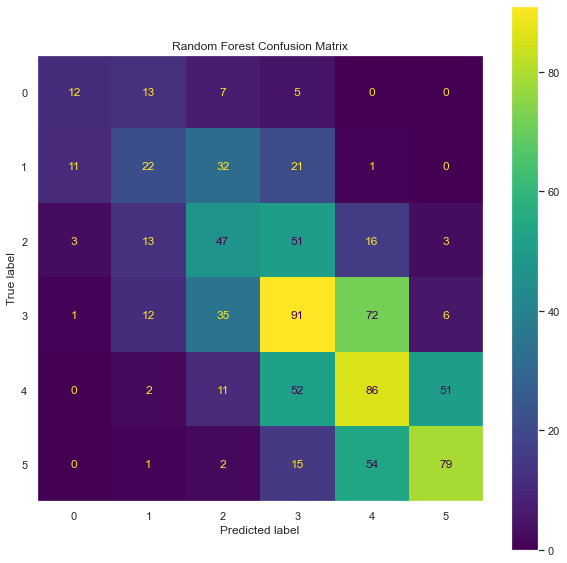

In [17]:
#Print confusion matrix for final Random Forest Model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Random Forest Confusion Matrix')
plt.grid(False)

In [18]:
#Again, get adjust accuarcy score. 
#It is bit higher than the Logistic model, but Logisitc has a higher raw accuarcy. 
y_pred = tree_final.predict(X_test)
total = 0
for idx, val in enumerate(y_pred):
    if ((y_pred[idx] == y_test.iloc[idx]) or (y_pred[idx] == y_test.iloc[idx] - 1)
                                          or (y_pred[idx] == y_test.iloc[idx] + 1)):
        total += 1
adjusted_accuracy = total/len(y_pred)
adjusted_accuracy

0.871825876662636

### Smurf Detection <a name="section6"></a>

Let's now simplify the model by making a smurf detector. Leagues 1-3 will be labeled as low and leagues 5-6 will be labelled as high. League 4 will be omitted to both simplify the model more and this isn't a common area for smurfing. 

In [19]:
#Omit the 4th League
starcraft_data = starcraft_data.drop(starcraft_data[(starcraft_data['LeagueIndex'] == 4)].index)
starcraft_data['LeagueIndex'].unique()

array([5, 3, 2, 1, 6], dtype=int64)

In [20]:
#Label leagues as high or low. 
starcraft_data['Level'] = np.where(((starcraft_data['LeagueIndex'] == 1) |
                     (starcraft_data['LeagueIndex'] == 2) |
                     (starcraft_data['LeagueIndex'] == 3)), 0 , 1)#Low is 0, high is 1
starcraft_data.head()

,GameID,LeagueIndex,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,Level
0,52,5,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000,1
1,55,5,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208,1
3,57,3,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384,0
4,58,3,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019,0
5,60,2,44.4570,0.000978,0.000255,2,0.000000,0.000000,0.002425,76.4405,98.7719,3.0965,16,0.000372,6,0.0,0.000000,0


In [21]:
#Since we have a new targer variable, we can drop the League Index. 
#We can also drop game id while we're at it. 
no_league = starcraft_data.drop(['LeagueIndex', 'GameID'], axis=1)
no_league.head()

,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,Level
0,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000,1
1,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208,1
3,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384,0
4,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019,0
5,44.4570,0.000978,0.000255,2,0.000000,0.000000,0.002425,76.4405,98.7719,3.0965,16,0.000372,6,0.0,0.000000,0


In [22]:
#Split and train newly labelled data. 
X = no_league.drop('Level', axis=1)
y = no_league['Level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
#Scale data same as before
robust = RobustScaler()
X_train = pd.DataFrame(robust.fit_transform(X_train), 
                       columns=no_league.drop('Level', axis=1).columns)
#Transform test data in the same manner as the training data. 
X_test = pd.DataFrame(robust.transform(X_test), 
                       columns=no_league.drop('Level', axis=1).columns)

#### K Nearest Neighbors <a name="section7"></a>

In [23]:
#Gridsearch a kneighbors classifier
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 50)}
knn_gs = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc_ovr')
knn_gs.fit(X_train, y_train)
print('Best parameter for n_neighbors is {}'.format(knn_gs.best_params_['n_neighbors']))
print('Scoring {}'.format(knn_gs.best_score_))

Best parameter for n_neighbors is 47
Scoring 0.9213965987363972


              precision    recall  f1-score   support

           0       0.81      0.83      0.82       268
           1       0.87      0.86      0.86       356

    accuracy                           0.84       624
   macro avg       0.84      0.84      0.84       624
weighted avg       0.84      0.84      0.84       624



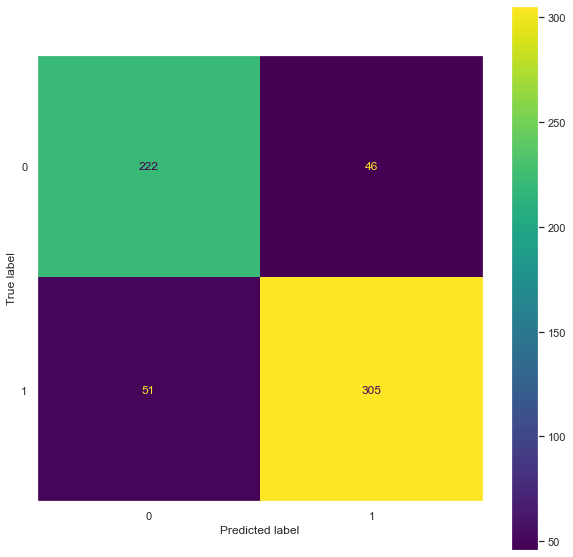

In [24]:
#Print out confusion matrix for final neighbors model.
knn_final = KNeighborsClassifier(n_neighbors=47)
knn_final.fit(X_train, y_train)
y_pred = knn_final.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
print(classification_report(y_test, y_pred))

#### Logistic Regression <a name="section8"></a>

In [25]:
#Gridsearch a logisitic regression model
log_final = LogisticRegression()
param_grid = {'C':np.logspace(-4, 4, 10), 'penalty': ['l1', 'l2']}
log_gs = GridSearchCV(log, param_grid, cv=5, scoring='roc_auc')
log_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='newton-cg'),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [26]:
#Get scores from gridsearching.
print('Best parameter for n_neighbors is {}'.format(log_gs.best_params_))
print('Scoring {}'.format(log_gs.best_score_))

Best parameter for n_neighbors is {'C': 0.3593813663804626, 'penalty': 'l2'}
Scoring 0.9277021761060966


              precision    recall  f1-score   support

           0       0.82      0.86      0.84       268
           1       0.89      0.85      0.87       356

    accuracy                           0.86       624
   macro avg       0.85      0.86      0.86       624
weighted avg       0.86      0.86      0.86       624



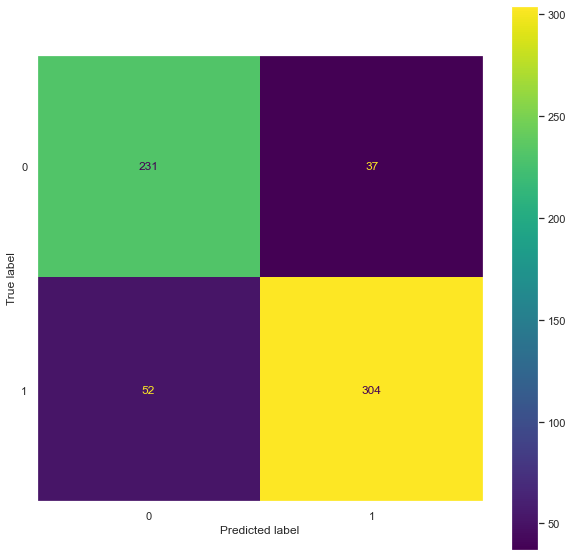

In [27]:
#Print out confusion matrix for final log model.
log_final = LogisticRegression(C=0.359, penalty='l2', solver='newton-cg')
log_final.fit(X_train, y_train)
y_pred = log_final.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
print(classification_report(y_test, y_pred))

#### Random Forest Classifier <a name="section9"></a>

In [29]:
#Creat a gridsearch a random forest classifier and print results
tree = RandomForestClassifier(random_state=10)
param_grid = { 
    'n_estimators': [10, 100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,3,5,7,9],
}
tree_gs = GridSearchCV(tree, param_grid, cv=5, scoring='roc_auc')
tree_gs.fit(X_train, y_train)
print('Best parameter for n_neighbors is {}'.format(tree_gs.best_params_))
print('Scoring {}'.format(tree_gs.best_score_))

Best parameter for n_neighbors is {'max_depth': 9, 'max_features': 'auto', 'n_estimators': 500}
Scoring 0.9278393224264893


              precision    recall  f1-score   support

           0       0.84      0.86      0.85       268
           1       0.89      0.88      0.89       356

    accuracy                           0.87       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.87      0.87      0.87       624



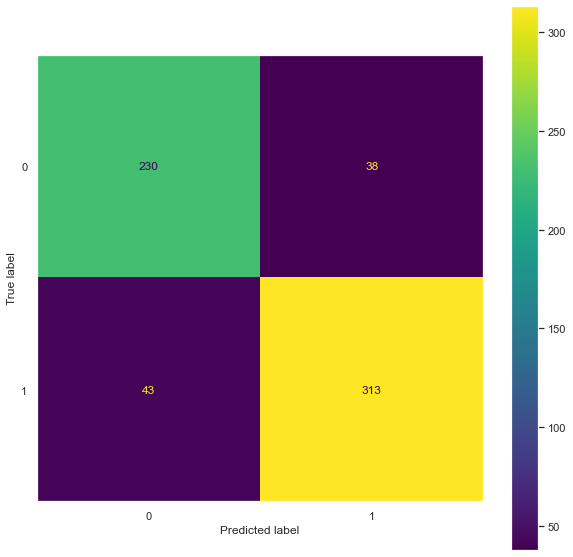

In [30]:
#Print confusion matrix for final tree model
tree_final = RandomForestClassifier(max_features='auto', max_depth=9, n_estimators=500)
tree_final.fit(X_train, y_train)
y_pred = tree_final.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
print(classification_report(y_test, y_pred))

### Thresholding <a name="section10"></a>
While the above recall rate is good for the Random Forest model, I want to do better. We want a high recall for this smurf detection. The reason is, if someone is labelled a smurf it's not a big deal. The system will adjust as send them back down based on their win/lose raito. Also, no one complains about some extra boost unless they are a smurf. We want to find as many true smurfs as possible so they can get out of their smurfing league. Their win/lose ratio will then hopefully keep them out.

Text(0.5, 1.0, 'ROC curves of three models')

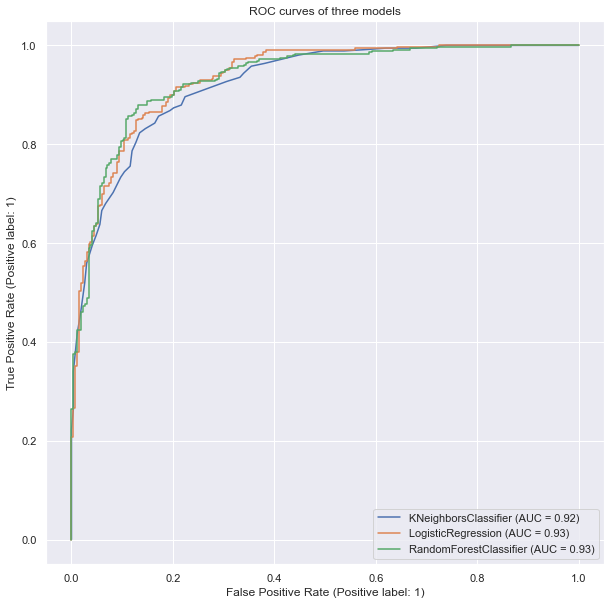

In [31]:
#Plot the roc curves from the three models on the same graph for comparision
from sklearn.metrics import plot_roc_curve
disp = plot_roc_curve(knn_final, X_test, y_test)
plot_roc_curve(log_final, X_test, y_test, ax=disp.ax_)
plot_roc_curve(tree_final, X_test, y_test, ax=disp.ax_)
plt.title('ROC curves of three models')

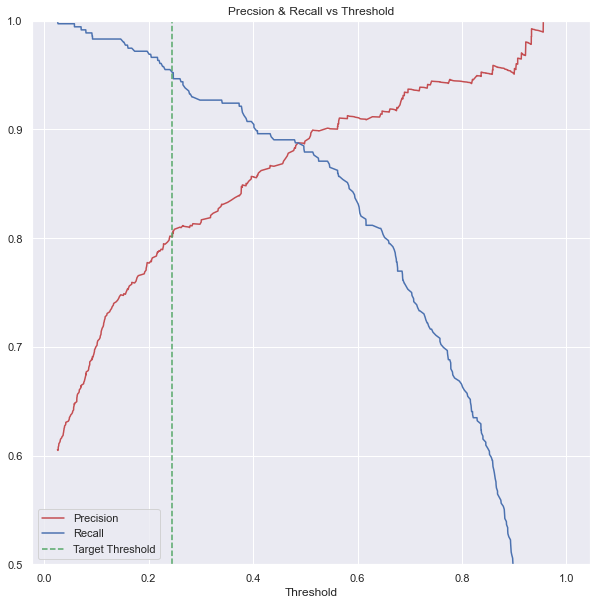

In [32]:
#Let's go with the Forest model since it has a slightly higher recall
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_test, tree_final.predict_proba(X_test)[:, 1])
plt.plot(threshold, precision[:-1], color='r', label='Precision')
plt.plot(threshold, recall[:-1], color='b', label='Recall')
plt.title('Precsion & Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylim([0.5, 1])
plt.axvline(x=0.245, label='Target Threshold', color='g', linestyle='--')
plt.legend(loc='lower left')

We pick the above threshold as we want to maximize recall. At 95% recall, we still have decent precision at 80%. After this point, precision drops off significantly. 

In [33]:
#Find where in recall that its value is ~95%. Use this index to get target threshold
idx = np.abs(recall - 0.95).argmin()
tar_thres = threshold[idx]
tar_thres

0.24727659883307576

              precision    recall  f1-score   support

           0       0.91      0.70      0.79       268
           1       0.81      0.95      0.87       356

    accuracy                           0.84       624
   macro avg       0.86      0.82      0.83       624
weighted avg       0.85      0.84      0.84       624



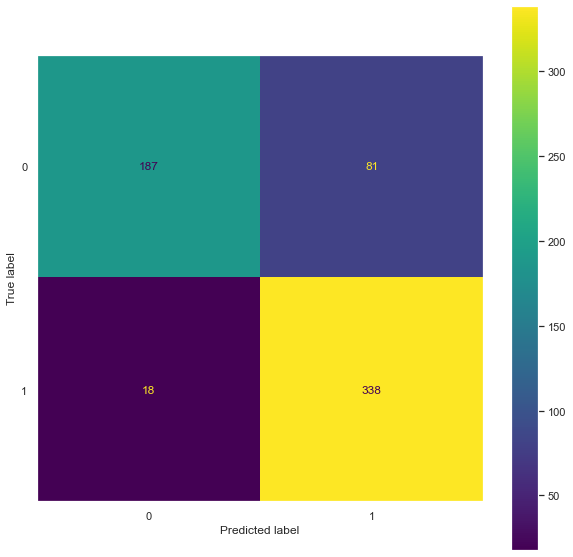

In [34]:
#Using this new threshold and the prediction probabilites provided by our model, 
#we will relabel our predictions.
y_probs = tree_final.predict_proba(X_test)
new_y_pred = np.where(y_probs[:, 1] > tar_thres, 1, 0)
#use these new predictios to make a confusion matrix and classification report
cm = confusion_matrix(y_test, new_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
print(classification_report(y_test, new_y_pred))

### Misclassifications <a name="section11"></a>
In this seciton, I will make a misclassifcation dataframe. This is done so that patterns amongst the data can be found and problems corrected. While I don't make note of patterns here, it is interesting to see for possible future examination.

In [35]:
#Redefine training and test sets without scaling
X = no_league.drop('Level', axis=1)
y = no_league['Level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
full_test_df = X_test.copy(deep=True) #Use X_test to get all features for predicted rows
full_test_df['y_true'] = y_test
full_test_df['y_pred_proba'] = y_probs[:, 1]

In [36]:
full_test_df

,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,y_true,y_pred_proba
677,101.0706,0.002351,0.000458,5,0.000458,0.000265,0.004039,25.7964,63.7731,4.2418,24,0.001170,7,0.0,0.000000,1,0.839978
1982,77.3160,0.002594,0.000620,10,0.000165,0.000393,0.003700,39.0252,63.3855,3.4246,26,0.000848,9,0.0,0.000372,1,0.778476
1350,85.2954,0.000980,0.000091,0,0.000000,0.000433,0.001686,49.5890,83.6216,8.8514,12,0.000820,4,0.0,0.000000,0,0.054447
3059,112.0380,0.002276,0.000251,6,0.000133,0.000340,0.003325,40.2321,58.8444,5.4356,15,0.001936,7,0.0,0.000000,1,0.785848
543,143.6058,0.005499,0.000669,1,0.000000,0.000086,0.004723,24.1835,43.6530,4.4977,12,0.000798,4,0.0,0.000086,1,0.917391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,78.8250,0.000045,0.000205,3,0.000000,0.000637,0.003185,45.6978,72.9714,4.6786,7,0.000341,4,0.0,0.000000,0,0.221722
3213,97.7454,0.003015,0.000296,3,0.000205,0.000330,0.002606,38.2105,84.2969,6.3144,20,0.001434,6,0.0,0.000000,0,0.278486
15,81.7722,0.002333,0.000430,4,0.000000,0.000249,0.002900,45.1654,64.7500,4.5312,15,0.001246,6,0.0,0.000227,1,0.486149
3155,25.4442,0.000385,0.000160,3,0.000192,0.000064,0.000994,113.2000,165.1613,4.3548,7,0.000385,2,0.0,0.000000,0,0.080178


In [37]:
full_test_df[full_test_df['y_true'] ==1].sort_values('y_pred_proba', ascending=True).head(20)

,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,y_true,y_pred_proba
2334,60.7074,0.001067,0.000243,6,0.000112,0.000393,0.002453,72.6462,84.0000,4.1298,20,0.000637,5,0.000000,0.000000,1,0.025561
1683,60.1158,0.000495,0.000237,4,0.000000,0.000215,0.002065,52.5895,88.7083,5.4375,11,0.000473,4,0.000000,0.000172,1,0.058052
969,90.2280,0.001482,0.000107,0,0.000021,0.000172,0.002684,50.6129,76.1600,5.8720,15,0.001074,6,0.000000,0.000000,1,0.070758
788,67.8690,0.000663,0.000282,10,0.000012,0.000061,0.003512,50.1754,73.6643,3.4685,16,0.000933,5,0.000049,0.000037,1,0.079828
27,74.1174,0.000875,0.000205,6,0.000018,0.000045,0.003518,46.4122,71.8173,3.7944,34,0.000929,5,0.000000,0.000000,1,0.091437
2580,79.0356,0.001025,0.000247,8,0.000104,0.000237,0.002505,35.7414,78.4848,5.6212,26,0.000750,6,0.000000,0.000000,1,0.092548
3203,66.1536,0.000805,0.000383,4,0.000000,0.000115,0.003028,38.9554,80.1772,3.9430,15,0.000901,6,0.000000,0.000077,1,0.146696
855,82.0194,0.002442,0.000306,3,0.000000,0.000225,0.003106,55.6040,75.3026,4.2533,23,0.000736,9,0.000215,0.000296,1,0.152711
1177,60.6252,0.001974,0.000351,5,0.000187,0.000070,0.003295,52.0285,68.0426,3.1950,23,0.000923,5,0.000000,0.000000,1,0.159587
659,78.8736,0.001289,0.000126,3,0.000000,0.000210,0.003210,43.7368,74.0437,4.2183,10,0.000701,6,0.000084,0.000070,1,0.167914


In [38]:
full_test_df[full_test_df['y_true'] ==0].sort_values('y_pred_proba', ascending=False).head(20)

,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,y_true,y_pred_proba
1702,127.0134,0.003093,0.000441,8,0.000144,0.000638,0.004136,43.7908,54.7130,4.9283,35,0.002131,7,0.000207,0.000405,0,0.955369
2598,142.7670,0.005962,0.000569,5,0.000000,0.000300,0.004015,34.4120,52.9403,5.3172,22,0.001168,7,0.000000,0.000165,0,0.933070
2097,140.7960,0.001992,0.000242,3,0.000091,0.000717,0.004528,27.3389,44.8267,5.0783,34,0.000928,6,0.000000,0.000000,0,0.932525
2519,136.1160,0.003263,0.000515,2,0.000041,0.000669,0.003552,31.0233,54.0406,6.5362,17,0.000947,7,0.000494,0.000525,0,0.921893
1180,128.6142,0.003892,0.000569,3,0.000180,0.000180,0.002754,24.7033,55.6087,7.3804,16,0.000569,4,0.000000,0.000030,0,0.921485
2397,157.3410,0.002981,0.000640,2,0.000000,0.000530,0.004717,23.6440,39.0705,5.7050,26,0.001921,7,0.000000,0.000000,0,0.913384
1857,118.5510,0.003857,0.000495,6,0.000059,0.000153,0.003999,41.3728,58.6667,4.7994,27,0.000743,8,0.000000,0.000059,0,0.906542
2915,115.2984,0.006638,0.000789,6,0.000026,0.000315,0.004009,34.4605,57.4295,3.8656,19,0.000684,6,0.000000,0.000145,0,0.902888
484,220.0692,0.013082,0.000230,5,0.000090,0.000064,0.004246,29.3897,42.5422,6.6747,22,0.001355,7,0.000179,0.000678,0,0.899870
2705,105.7434,0.003914,0.000411,6,0.000298,0.000401,0.003000,44.1375,65.3014,5.9349,23,0.001479,7,0.000205,0.000154,0,0.858952
